# Import libraries

In [487]:
import importlib
import semseg_functions
importlib.reload(semseg_functions)

from semseg_functions import load_imgs_labels,train_model,make_predictions
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

# Load Data

In [488]:
# Load the Data from pickle file.
urothelial_cells=pd.read_pickle("urothelial_cell_toy_data.pkl")
images=np.transpose(urothelial_cells["X"].numpy()*255,(0,2,3,1)).astype(np.uint8)
labels=urothelial_cells["y"]

# Splitting the Data into Training and Validation Sets. 
X_train,X_val,Y_train,Y_val=train_test_split(
  images,labels,
  # test_size=0.2: 20% of the data is reserved for validation and 80% for training.
  test_size=0.2,
  # The condition >= np.median(labels.mean((1, 2))) creates a binary mask (True/False) 
  # based on whether the mean value is above or below the median.
  stratify=labels.mean((1,2))>=np.median(labels.mean((1,2))),
  random_state=42
  )

# Converting Data to PyTorch Tensors
X_train,X_val,Y_train,Y_val=(
  torch.FloatTensor(X_train).permute((0,3,1,2)),
  torch.FloatTensor(X_val).permute((0,3,1,2)),
  torch.LongTensor(Y_train),
  torch.LongTensor(Y_val)
  )

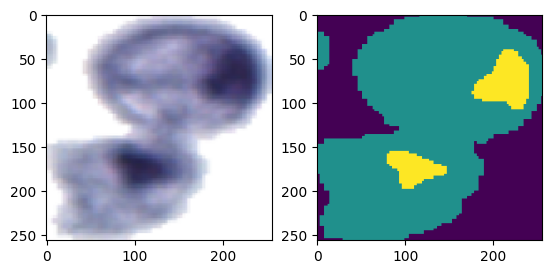

In [489]:
# plt.subplot(1, 2, 1) creates a 1-row, 2-column grid of subplots and selects the first subplot (index 1) for plotting.
plt.subplot(1,2,1)
plt.imshow(images[0])
# selects the second subplot (index 2) for plotting.
plt.subplot(1,2,2)
plt.imshow(labels[0])

# Train model

In [490]:
# Calls a function train_model from semseg_functions.py to train a deep learning model
# resnet34 refers to the ResNet-34 architecture, a popular convolutional neural network (CNN) backbone.
model = train_model(X_train, Y_train, X_val, Y_val, encoder_name="densenet121", model_key="seunettrans", n_epochs=200)


model= seunettrans. Using Combo Loss and Lower Learning Rate
Model: seunettrans, Encoder: densenet121. Training: Epoch 1, Batch 0, Loss: 10.714
Model: seunettrans, Encoder: densenet121. Training: Epoch 1, Batch 1, Loss: 10.422
Model: seunettrans, Encoder: densenet121. Training: Epoch 1, Batch 2, Loss: 10.737
Model: seunettrans, Encoder: densenet121. Training: Epoch 1, Batch 3, Loss: 10.182
Model: seunettrans, Encoder: densenet121. Training: Epoch 1, Batch 4, Loss: 9.15
Model: seunettrans, Encoder: densenet121. Training: Epoch 1, Batch 5, Loss: 10.064
Model: seunettrans, Encoder: densenet121. Training: Epoch 1, Batch 6, Loss: 9.315
Model: seunettrans, Encoder: densenet121. Training: Epoch 1, Batch 7, Loss: 9.872
Model: seunettrans, Encoder: densenet121. Training: Epoch 1, Batch 8, Loss: 8.964
Model: seunettrans, Encoder: densenet121. Training: Epoch 1, Batch 9, Loss: 9.368
Model: seunettrans, Encoder: densenet121. Training: Epoch 1, Batch 10, Loss: 8.157
Model: seunettrans, Encoder: den

# Predict on held out test

In [491]:
# calls a function make_predictions to generate predictions (y_val_pred) for the validation data (X_val)
# Since model_key="seunettrans" is passed to the train_model function, the seUNet-Tans model is selected and used for training.
y_val_pred=make_predictions(X_val, encoder_name="densenet121", model_key="seunettrans")#,model=model)#model=None)

In [492]:
y_val_pred_lbls=y_val_pred.argmax(1)

# Report segmentation model performance

In [493]:
from sklearn.metrics import classification_report

In [494]:
print(classification_report(Y_val.numpy().flatten(),y_val_pred_lbls.flatten()))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96    980301
           1       0.92      0.87      0.89   1117270
           2       0.81      0.90      0.85    523869

    accuracy                           0.91   2621440
   macro avg       0.90      0.91      0.90   2621440
weighted avg       0.91      0.91      0.91   2621440



# Compare true and predicted NC ratios

In [495]:
nucleus_pred=(y_val_pred_lbls.reshape(y_val_pred_lbls.shape[0],-1)==2).sum(axis=1)
cytoplasm_pred=(y_val_pred_lbls.reshape(y_val_pred_lbls.shape[0],-1)==1).sum(axis=1)
nc_ratio_pred=nucleus_pred/(nucleus_pred+cytoplasm_pred)

In [496]:
nucleus_true=(Y_val.reshape(Y_val.shape[0],-1)==2).sum(axis=1)
cytoplasm_true=(Y_val.reshape(Y_val.shape[0],-1)==1).sum(axis=1)
nc_ratio_true=nucleus_true/(nucleus_true+cytoplasm_true)

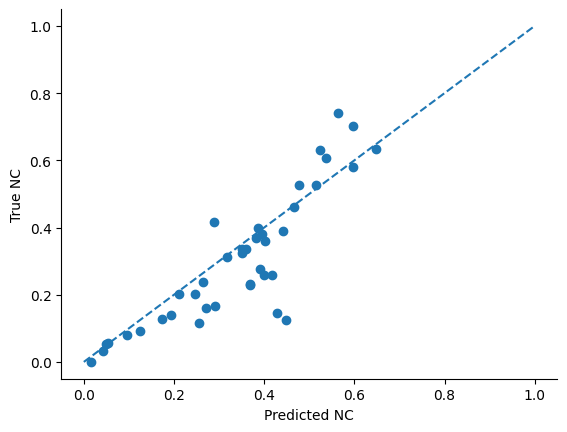

In [497]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(nc_ratio_pred,nc_ratio_true)
plt.plot([0,1],[0,1],ls="--")
plt.xlabel("Predicted NC")
plt.ylabel("True NC")
sns.despine()

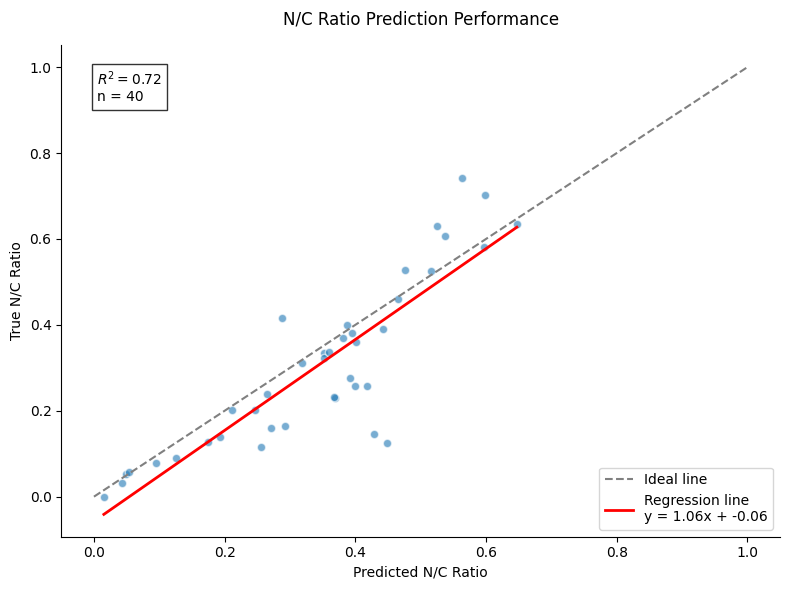

In [498]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


plt.figure(figsize=(8, 6))
plt.scatter(nc_ratio_pred, nc_ratio_true, alpha=0.6, edgecolor='w')

reg = LinearRegression().fit(nc_ratio_pred.reshape(-1, 1), nc_ratio_true)
slope = reg.coef_[0]
intercept = reg.intercept_
r2 = r2_score(nc_ratio_true, nc_ratio_pred)

x_range = np.linspace(min(nc_ratio_pred), max(nc_ratio_pred), 100)
y_reg = reg.predict(x_range.reshape(-1, 1))

plt.plot([0, 1], [0, 1], ls="--", c='gray', label='Ideal line')  
plt.plot(x_range, y_reg, c='red', lw=2, 
         label=f'Regression line\ny = {slope:.2f}x + {intercept:.2f}')

plt.text(0.05, 0.95, 
         f'$R^2 = {r2:.2f}$\nn = {len(nc_ratio_true)}', 
         transform=plt.gca().transAxes,
         ha='left', va='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.xlabel("Predicted N/C Ratio")
plt.ylabel("True N/C Ratio")
plt.title("N/C Ratio Prediction Performance", pad=15)
plt.legend(loc='lower right', frameon=True)
sns.despine()

plt.tight_layout()
plt.show()

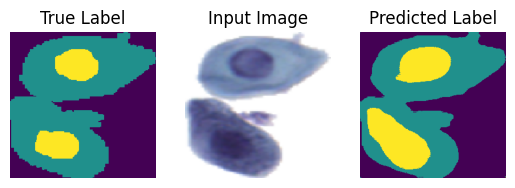

In [499]:
# ! mkdir DL_result_imgs
for idx in range(len(X_val)):
    plt.subplot(131)
    plt.imshow(Y_val[idx])
    plt.axis("off")
    plt.title("True Label")
    plt.subplot(132)
    plt.imshow((X_val[idx]).permute((1,2,0)).numpy().astype(int))
    plt.axis("off")
    plt.title("Input Image")
    plt.subplot(133)
    plt.imshow(y_val_pred_lbls[idx])
    plt.axis("off")
    plt.title("Predicted Label")
    plt.savefig(f"DL_result_imgs/urothelial_cell_{idx}.png")

In [500]:
# correlation - true vs predicted
spearmanr(nc_ratio_pred,nc_ratio_true)

SignificanceResult(statistic=np.float64(0.8429643527204504), pvalue=np.float64(8.868502010991051e-12))

In [501]:
# error - true vs predicted
np.abs(nc_ratio_pred-nc_ratio_true.numpy()).mean()

np.float64(0.07075257968559302)

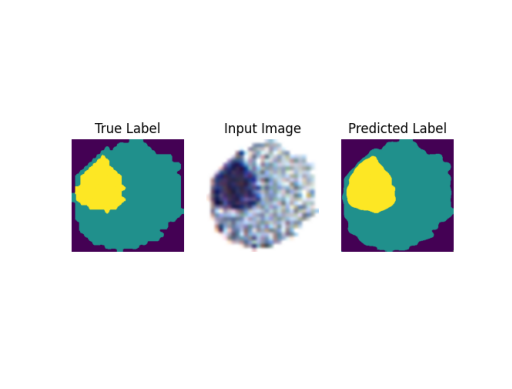

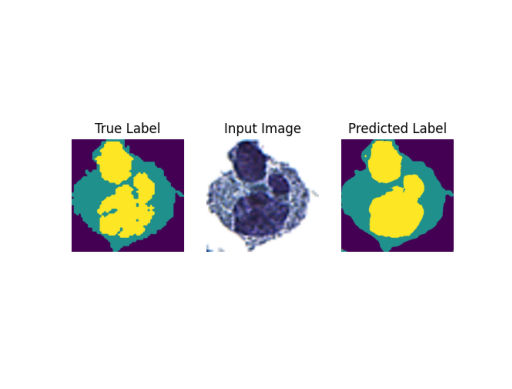

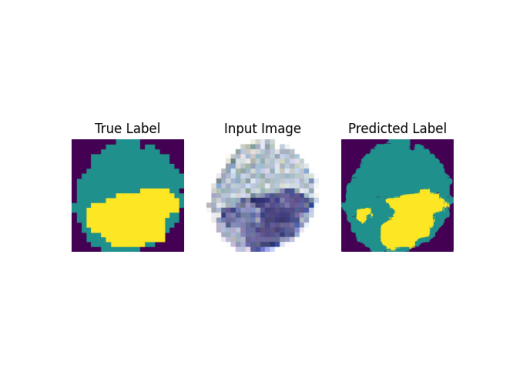

In [502]:
import matplotlib.pyplot as plt
result_images="""DL_result_imgs/urothelial_cell_11.png
DL_result_imgs/urothelial_cell_21.png
DL_result_imgs/urothelial_cell_22.png""".splitlines()

for img in result_images:
    plt.figure()
    plt.imshow(plt.imread(img))
    plt.axis("off")
    plt.show()


# Model Predictive Power Validation

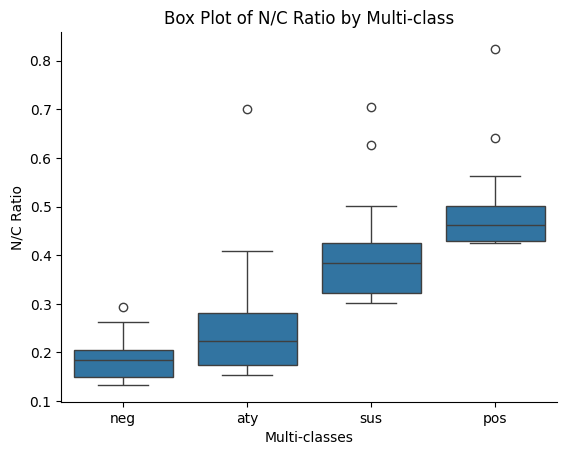

In [503]:
sps=pd.read_pickle("specimens_toy_data.pkl")
df=pd.concat([sps[k]["metadata"].assign(class_=lambda x: k) for k in sps])
df["class_"]=pd.Categorical(df["class_"],["neg","aty","sus","pos"])
sns.boxplot(x="class_",y="nc_ratio",data=df)
plt.xlabel("Multi-classes")
plt.ylabel("N/C Ratio")
plt.title("Box Plot of N/C Ratio by Multi-class")
sns.despine()
plt.show()

In [504]:
from sklearn.linear_model import LogisticRegression

# Prepare features and labels
X = df[["nc_ratio"]].values  # Feature: N/C ratio
y = df["class_"].values 

# Split into training and testing sets, test_size=0.2 (20 in total)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         aty       0.50      0.20      0.29         5
         neg       0.56      1.00      0.71         5
         pos       0.62      1.00      0.77         5
         sus       1.00      0.20      0.33         5

    accuracy                           0.60        20
   macro avg       0.67      0.60      0.53        20
weighted avg       0.67      0.60      0.53        20



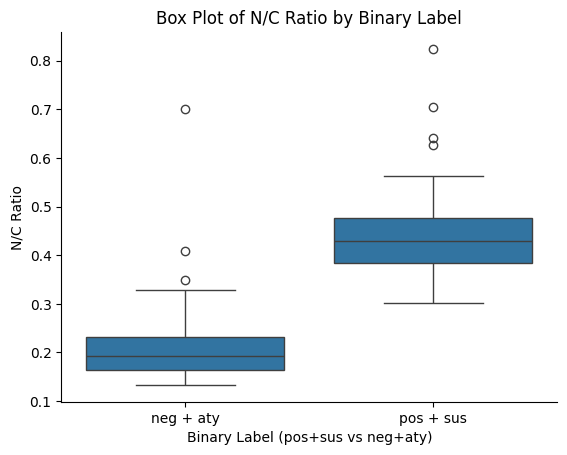

In [505]:
df["binary_label"] = df["class_"].apply(lambda x: "pos + sus" if x in ["sus", "pos"] else "neg + aty")

sns.boxplot(x="binary_label", y="nc_ratio", data=df)
plt.xlabel("Binary Label (pos+sus vs neg+aty)")
plt.ylabel("N/C Ratio")
plt.title("Box Plot of N/C Ratio by Binary Label")
sns.despine()
plt.show()

In [506]:
# Prepare features and labels
X = df[["nc_ratio"]].values  # Feature: N/C ratio
y = df["binary_label"].values  # Binary labels

# Split into training and testing sets, test_size=0.2 (20 in total)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   neg + aty       0.83      1.00      0.91        10
   pos + sus       1.00      0.80      0.89        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20



In [507]:
from functools import reduce
import cv2

resize = lambda x: cv2.resize(x,(256,256),interpolation=cv2.INTER_CUBIC)
all_images=reduce(lambda x,y: x+y,[list(map(resize,sps[k]["imgs"])) for k in sps])

# Generate predictions using seUNet-Trans
all_images_tensor = torch.FloatTensor(np.array(all_images)).permute((0, 3, 1, 2))
all_predictions = make_predictions(all_images_tensor, encoder_name="densenet121", model_key="seunettrans")
all_pred_labels = all_predictions.argmax(1)

# Calculate N/C ratio for each image
nucleus_pred = (all_pred_labels.reshape(all_pred_labels.shape[0], -1) == 2).sum(axis=1)
cytoplasm_pred = (all_pred_labels.reshape(all_pred_labels.shape[0], -1) == 1).sum(axis=1)
nc_ratio_pred = nucleus_pred / (nucleus_pred + cytoplasm_pred)


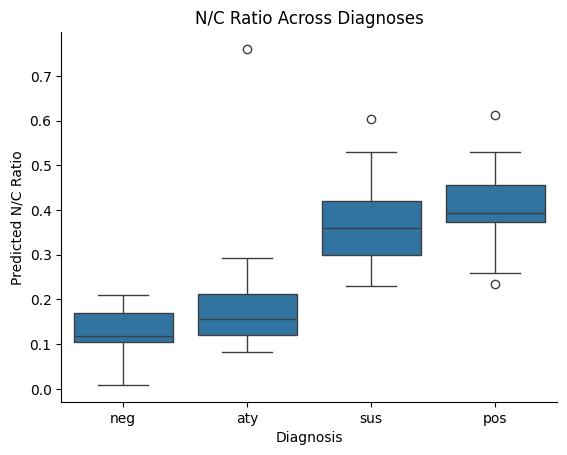

In [508]:
df["nc_ratio_pred"] = nc_ratio_pred

# Visualize N/C ratio across diagnoses
sns.boxplot(x="class_", y="nc_ratio_pred", data=df)
plt.xlabel("Diagnosis")
plt.ylabel("Predicted N/C Ratio")
plt.title("N/C Ratio Across Diagnoses")
sns.despine()
plt.show()

In [509]:
print(X[:5])  # Confirm the input is from nc_ratio
print(df[["nc_ratio", "nc_ratio_pred"]].head())  # Verify difference
print(y_pred[:5])  # Check the predicted labels
print(y_test[:5])  # Check the true labels

[[0.14192775]
 [0.17562475]
 [0.15078207]
 [0.1824368 ]
 [0.18371184]]
   nc_ratio  nc_ratio_pred
0  0.141928       0.112746
1  0.175625       0.180414
2  0.150782       0.123435
3  0.182437       0.135376
4  0.183712       0.112788
['pos + sus' 'neg + aty' 'pos + sus' 'pos + sus' 'neg + aty']
['pos + sus' 'pos + sus' 'pos + sus' 'pos + sus' 'neg + aty']


In [510]:

# Prepare features and labels
X = df[["nc_ratio_pred"]].values
y = df["class_"].values

# Stratified splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train logistic regression model
model_m = LogisticRegression(random_state=42)
model_m.fit(X_train, y_train)

# Make predictions
y_pred = model_m.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         aty       0.50      0.20      0.29         5
         neg       0.50      1.00      0.67         5
         pos       0.71      1.00      0.83         5
         sus       1.00      0.20      0.33         5

    accuracy                           0.60        20
   macro avg       0.68      0.60      0.53        20
weighted avg       0.68      0.60      0.53        20



In [511]:

# Spearman correlation between predicted and true N/C ratios
spearman_corr = spearmanr(df["nc_ratio"], df["nc_ratio_pred"], nan_policy="omit")
print(f"Spearman Correlation: {spearman_corr.correlation:.2f}, p-value: {spearman_corr.pvalue:.2e}")

Spearman Correlation: 0.86, p-value: 5.29e-30


In [512]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Prepare data for ordinal regression
df["class_ordinal"] = df["class_"].cat.codes  # Convert categories to ordinal values
model = OrderedModel(df["class_ordinal"], df["nc_ratio_pred"], distr="logit")
result = model.fit(method="bfgs")
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.989040
         Iterations: 17
         Function evaluations: 19
         Gradient evaluations: 19
                             OrderedModel Results                             
Dep. Variable:          class_ordinal   Log-Likelihood:                -98.904
Model:                   OrderedModel   AIC:                             205.8
Method:            Maximum Likelihood   BIC:                             216.2
Date:                Tue, 13 May 2025                                         
Time:                        19:59:57                                         
No. Observations:                 100                                         
Df Residuals:                      96                                         
Df Model:                           1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

In [513]:

# Display key metrics
print(f"Spearman Correlation: {spearman_corr.correlation:.2f}")
print(f"Ordinal Regression Summary:\n{result.summary()}")

Spearman Correlation: 0.86
Ordinal Regression Summary:
                             OrderedModel Results                             
Dep. Variable:          class_ordinal   Log-Likelihood:                -98.904
Model:                   OrderedModel   AIC:                             205.8
Method:            Maximum Likelihood   BIC:                             216.2
Date:                Tue, 13 May 2025                                         
Time:                        19:59:57                                         
No. Observations:                 100                                         
Df Residuals:                      96                                         
Df Model:                           1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
nc_ratio_pred    15.4509      2.210      6.990      0.000      11.119 

In [514]:
print(X[:5])  # Confirm the input is from nc_ratio
print(df[["nc_ratio", "nc_ratio_pred"]].head())  # Verify difference
print(y_pred[:5])  # Check the predicted labels
print(y_test[:5])  # Check the true labels


[[0.11274623]
 [0.18041373]
 [0.12343498]
 [0.13537603]
 [0.11278768]]
   nc_ratio  nc_ratio_pred
0  0.141928       0.112746
1  0.175625       0.180414
2  0.150782       0.123435
3  0.182437       0.135376
4  0.183712       0.112788
['pos' 'neg' 'pos' 'neg' 'aty']
['pos', 'aty', 'pos', 'neg', 'aty']
Categories (4, object): ['neg', 'aty', 'sus', 'pos']


In [515]:
# Ensure binary_label is created correctly
df["binary_label"] = df["class_"].apply(lambda x: "pos + sus" if x in ["sus", "pos"] else "neg + aty")

# Prepare features and labels
X = df[["nc_ratio_pred"]].values
y = df["binary_label"].values

# Stratified splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train logistic regression model
model_b = LogisticRegression(random_state=42)
model_b.fit(X_train, y_train)

# Make predictions
y_pred = model_b.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   neg + aty       0.91      1.00      0.95        10
   pos + sus       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



In [516]:
print(X[:5])  # Confirm the input is from nc_ratio_pred
print(df[["nc_ratio", "nc_ratio_pred"]])  # Verify difference
print(y_pred[:5])  # Check the predicted labels
print(y_test[:5])  # Check the true labels


[[0.11274623]
 [0.18041373]
 [0.12343498]
 [0.13537603]
 [0.11278768]]
    nc_ratio  nc_ratio_pred
0   0.141928       0.112746
1   0.175625       0.180414
2   0.150782       0.123435
3   0.182437       0.135376
4   0.183712       0.112788
..       ...            ...
20  0.359070       0.280096
21  0.304277       0.381863
22  0.424544       0.488123
23  0.386391       0.311697
24  0.327733       0.353276

[100 rows x 2 columns]
['pos + sus' 'pos + sus' 'pos + sus' 'pos + sus' 'neg + aty']
['pos + sus' 'pos + sus' 'pos + sus' 'pos + sus' 'neg + aty']


In [ ]:

sns.boxplot(x="binary_label", y="nc_ratio_pred", data=df)
plt.ylabel("N/C Ratio")
plt.title("Box Plot of N/C Ratio by Binary Label - Predicted")
sns.despine()
plt.show()

NameError: name 'sns' is not defined